VIDEO PESENTATION: (https://drive.google.com/file/d/1U52O_RgMSRfiveY7qAdrJhthLUke8BVR/view?usp=sharing)

 ## The primary objective of this project is to build a classification model that can automatically
 ## categorize news articles into different predefined categories. The model will be trained using
 ## a labeled dataset of news articles and will output the most likely category (e.g., sports,
 ## politics, or technology) for any given article.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Collection and Preprocessing:

In [2]:
# Load dataset (replace with your file path if needed)
df = pd.read_csv("data_news.csv")

# Quick look at the dataset
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (50000, 5)
   category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want t

In [3]:
# Checked for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Dropped rows with missing text or category
df = df.dropna(subset=['category', 'short_description']).reset_index(drop=True)

# Filled missing keywords with placeholder
df['keywords'] = df['keywords'].fillna("unknown")



Missing values per column:
 category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64


In [4]:

# Import necessary NLTK components
stop_words = set(stopwords.words('english'))  # Load English stopwords to filter out common non-informative words
lemmatizer = WordNetLemmatizer()  # Initialize WordNet lemmatizer to reduce words to their base form

# Define a text cleaning function
def clean_text(text):
    text = text.lower()                   #Convert all characters to lowercase for uniformity
    text = re.sub(r'[^a-z\s]', '', text)  # Remove all non-letter characters (punctuation, numbers, etc.)
    tokens = text.split()                 # Tokenize the text by splitting on whitespace
    tokens = [w for w in tokens if w not in stop_words]  # Remove stopwords from the token list
    tokens = [lemmatizer.lemmatize(w) for w in tokens]  # Lemmatize each token to its root form
    return " ".join(tokens)                             # Rejoin the cleaned tokens into a single string

# Apply the cleaning function to the 'short_description' column
df['clean_text'] = df['short_description'].apply(clean_text)

# Optionally combine 'headline' and 'short_description' for richer context, then clean
df['combined_text'] = (df['headline'].fillna('') + " " + df['short_description']).apply(clean_text)

# Preview the cleaned output alongside original category and description
df[['category', 'short_description', 'clean_text']].head()



,category,short_description,clean_text
0,WELLNESS,Resting is part of training. I've confirmed wh...,resting part training ive confirmed sort alrea...
1,WELLNESS,Think of talking to yourself as a tool to coac...,think talking tool coach challenge narrate exp...
2,WELLNESS,The clock is ticking for the United States to ...,clock ticking united state find cure team work...
3,WELLNESS,"If you want to be busy, keep trying to be perf...",want busy keep trying perfect want happy focus...
4,WELLNESS,"First, the bad news: Soda bread, corned beef a...",first bad news soda bread corned beef beer hig...


 # 2. Feature Extraction 

In [5]:
## Bag-of-Words vectorization: captures word frequency for unigrams (single words)
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))  # Limit to top 5000 most frequent unigrams
X_bow = bow_vectorizer.fit_transform(df['clean_text'])  # Transform cleaned text into sparse matrix of word counts

# TF-IDF vectorization: captures term importance using unigrams and bigrams (single words + two-word phrases)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Limit to top 5000 features including bigrams
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])  # Transform cleaned text into weighted matrix of term importance

# Print the shape of resulting feature matrices
print("BoW shape:", X_bow.shape)       # Output: (number of samples, number of features)
print("TF-IDF shape:", X_tfidf.shape)  # Output: (number of samples, number of features)


BoW shape: (50000, 5000)
TF-IDF shape: (50000, 5000)


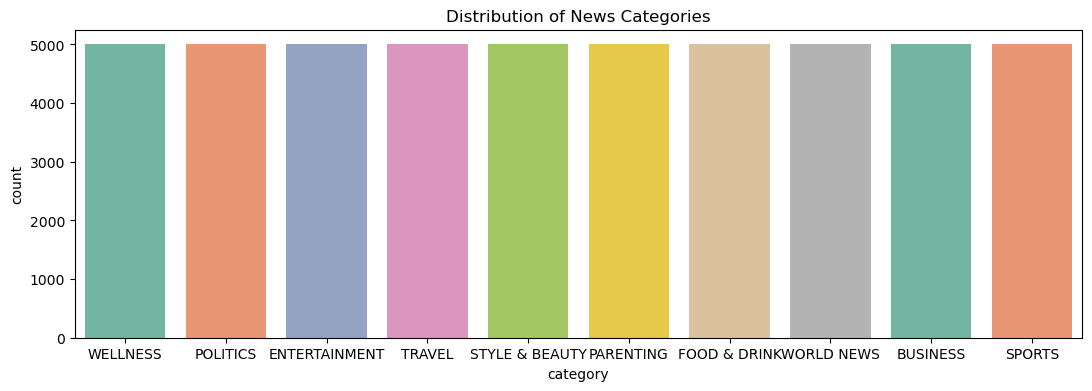

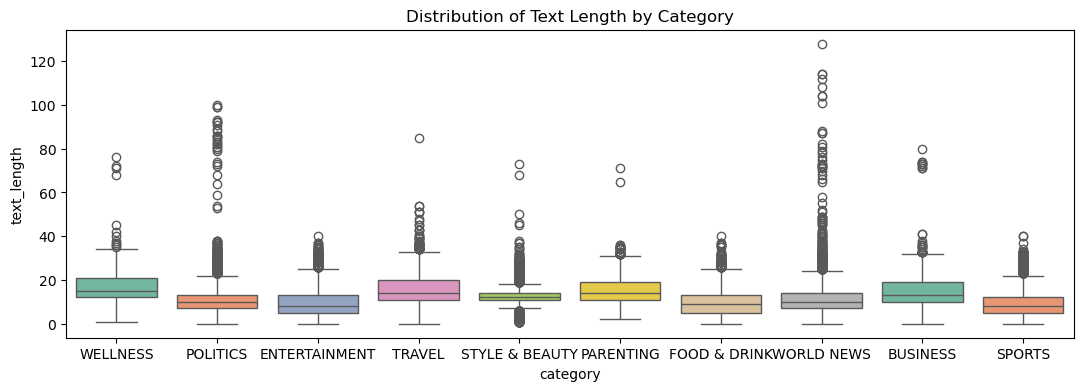

In [6]:

# Plot the count of articles per category
plt.figure(figsize=(13,4))
sns.countplot(data=df, x='category', hue='category', palette="Set2", legend=False)  # Count plot with colored bars per category
plt.title("Distribution of News Categories")
plt.show()

# Calculate text length (number of words) for each cleaned description
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Plot boxplot of text length distribution across categories
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='category', y='text_length', hue='category', palette="Set2", legend=False)  # Boxplot showing spread of word counts
plt.title("Distribution of Text Length by Category")
plt.show()



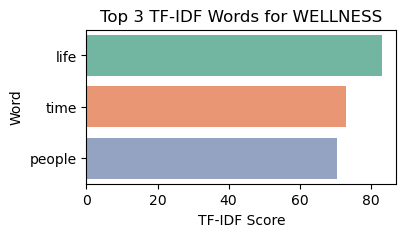

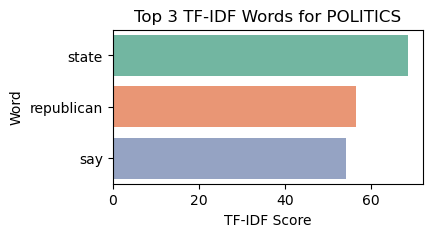

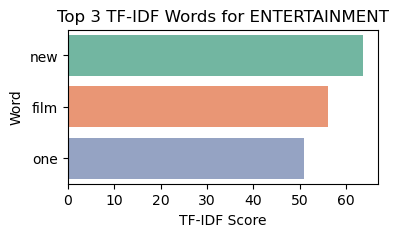

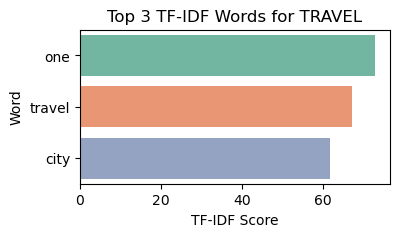

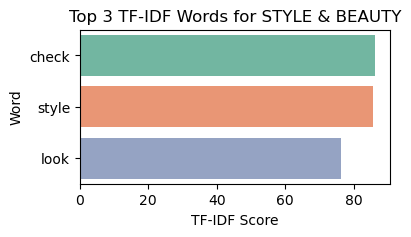

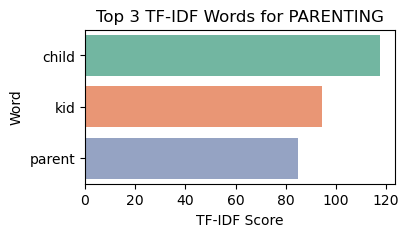

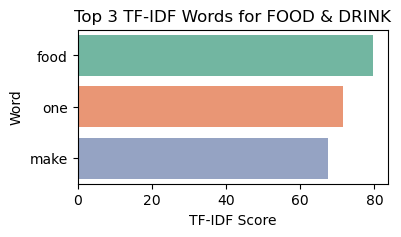

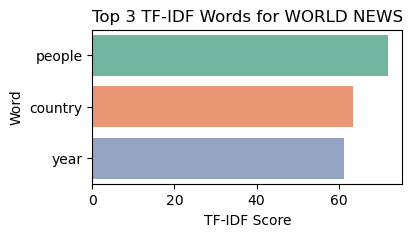

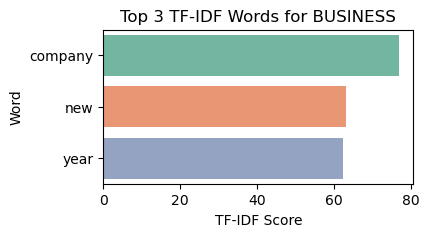

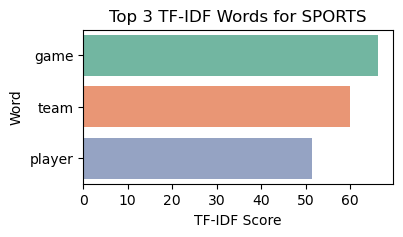

In [7]:
#function for top words
def plot_top_tfidf_words(category, top_n=10):
    # Filter rows for this category
    texts = df[df['category']==category]['clean_text']
    
    # Fit TF-IDF on this subset
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X = tfidf.fit_transform(texts)
    
    # Sum TF-IDF scores across all docs
    scores = np.asarray(X.sum(axis=0)).flatten()
    top_indices = scores.argsort()[::-1][:top_n]
    top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]
    top_scores = [scores[i] for i in top_indices]
    
    # Plot
    plt.figure(figsize=(4,2))
    sns.barplot(x=top_scores, y=top_words, hue=top_words,palette="Set2", legend=False)

    plt.title(f"Top {top_n} TF-IDF Words for {category}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Word")
    plt.show()

# Example: plot for each category
for cat in df['category'].unique():
    plot_top_tfidf_words(cat, top_n=3)

 # 3. Model Development and Training with Evaluation


🔹 Training and evaluating Logistic Regression...
                precision    recall  f1-score   support

      BUSINESS       0.66      0.65      0.65      1000
 ENTERTAINMENT       0.54      0.58      0.56      1000
  FOOD & DRINK       0.66      0.74      0.70      1000
     PARENTING       0.66      0.63      0.65      1000
      POLITICS       0.63      0.58      0.61      1000
        SPORTS       0.68      0.70      0.69      1000
STYLE & BEAUTY       0.72      0.69      0.70      1000
        TRAVEL       0.68      0.65      0.67      1000
      WELLNESS       0.62      0.66      0.64      1000
    WORLD NEWS       0.68      0.65      0.66      1000

      accuracy                           0.65     10000
     macro avg       0.65      0.65      0.65     10000
  weighted avg       0.65      0.65      0.65     10000



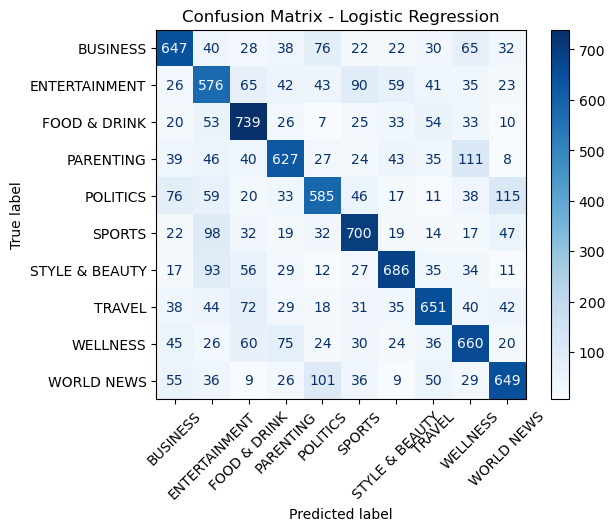


🔹 Training and evaluating Naive Bayes...
                precision    recall  f1-score   support

      BUSINESS       0.61      0.61      0.61      1000
 ENTERTAINMENT       0.59      0.52      0.55      1000
  FOOD & DRINK       0.64      0.75      0.69      1000
     PARENTING       0.54      0.66      0.59      1000
      POLITICS       0.63      0.57      0.60      1000
        SPORTS       0.74      0.62      0.67      1000
STYLE & BEAUTY       0.73      0.64      0.68      1000
        TRAVEL       0.65      0.65      0.65      1000
      WELLNESS       0.57      0.64      0.60      1000
    WORLD NEWS       0.68      0.67      0.67      1000

      accuracy                           0.63     10000
     macro avg       0.64      0.63      0.63     10000
  weighted avg       0.64      0.63      0.63     10000



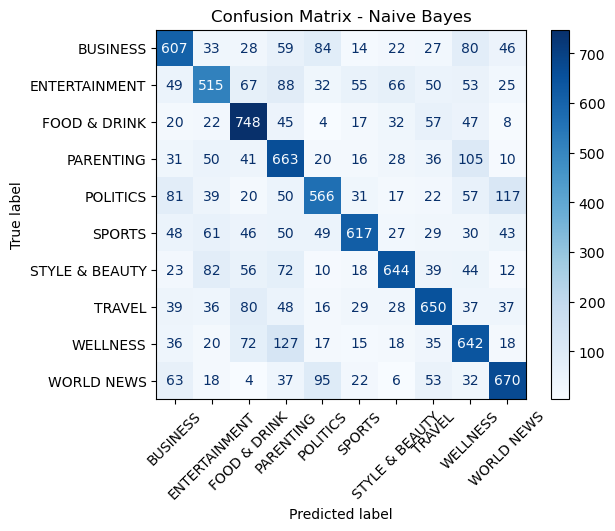


🔹 Training and evaluating SVM...
                precision    recall  f1-score   support

      BUSINESS       0.66      0.68      0.67      1000
 ENTERTAINMENT       0.54      0.55      0.54      1000
  FOOD & DRINK       0.65      0.72      0.68      1000
     PARENTING       0.65      0.62      0.63      1000
      POLITICS       0.61      0.55      0.57      1000
        SPORTS       0.68      0.73      0.70      1000
STYLE & BEAUTY       0.70      0.70      0.70      1000
        TRAVEL       0.68      0.63      0.65      1000
      WELLNESS       0.61      0.64      0.63      1000
    WORLD NEWS       0.66      0.65      0.65      1000

      accuracy                           0.65     10000
     macro avg       0.65      0.65      0.64     10000
  weighted avg       0.65      0.65      0.64     10000



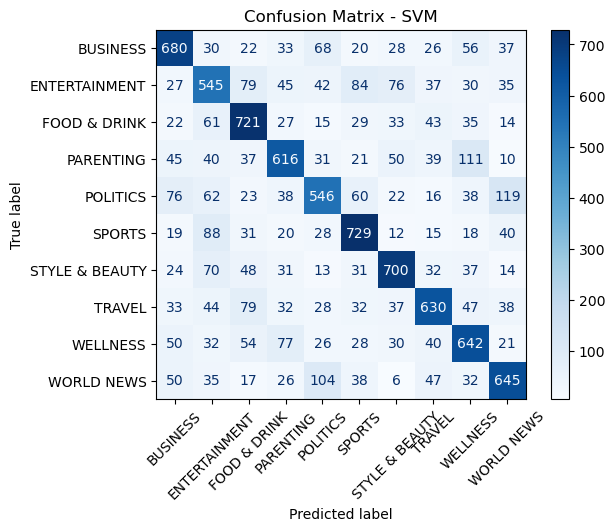


📊 Model Comparison:
                  Model  Accuracy  Precision  Recall  F1-score  CV Mean F1
0  Logistic Regression    0.6520   0.653375  0.6520  0.652055    0.635765
1          Naive Bayes    0.6322   0.637487  0.6322  0.632322    0.620575
2                  SVM    0.6454   0.645280  0.6454  0.644703    0.613905


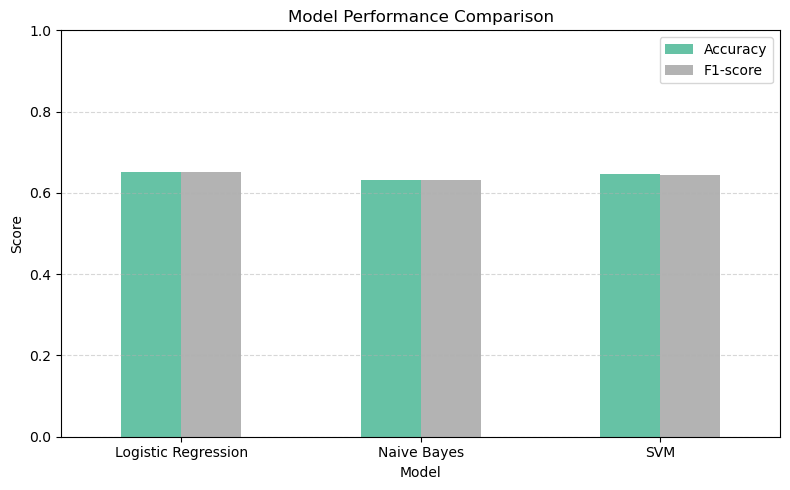

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score


# 🔹 Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,                     # TF-IDF features from previous step
    df['category'],              # Target labels (news categories)
    test_size=0.2,               # Reserve 20% of data for testing
    stratify=df['category'],     # Ensure balanced category distribution
    random_state=42              # Set seed for reproducibility
)

# 🔹 Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, C=1.0),
    "Naive Bayes": MultinomialNB(alpha=1.0),
    "SVM": LinearSVC(C=1.0)
}

# 🔹 Train, evaluate, and visualize each model
results = []  # Store evaluation metrics

for name, model in models.items():
    print(f"\n🔹 Training and evaluating {name}...")
    
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    
    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(classification_report(y_test, y_pred))  # Detailed report
    
    # Cross-validation for robustness
    cv_scores = cross_val_score(model, X_tfidf, df['category'], cv=5, scoring='f1_macro')
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "CV Mean F1": cv_scores.mean()
    })
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# 🔹 Compare model performance
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison:\n", results_df)

#Visual comparison using bar chart
results_df.set_index("Model")[["Accuracy","F1-score"]].plot(
    kind="bar", figsize=(8,5), colormap="Set2"
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal gridlines
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Insights:

# THANK YOU